In [1]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.5*3.125, 1.5*1.5],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import pathlib
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
%run '../util/webrtc_reader.py'
%run '../util/helper_functions.py'

In [3]:
dataset = '13May'
data_dir = '/scratch/datasets/vcqoe'
cross_validations = 5
tested_vcas = ['meet', 'teams']
traces_available = False
timestamps_available = False
metrics = ['framesReceivedPerSecond', 'bitrate', 'frame_jitter', 'frameHeight']

In [4]:
model_name_lookup = {
        'IP/UDP ML': '{}_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'IP/UDP Heuristic': '{}_frame-lookback_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP ML': '{}_rtp_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP Heuristic': '{}_rtp_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original'
}

col_map = {
        '{}_{}': 'Prediction',
        '{}_gt': 'Ground Truth',
        'throughput_mean_kbps': 'Throughput Mean (Kbps)',
        'throughput_std_kbps': 'Throughput Jitter (Kbps)',
        'latency_mean_ms': 'Latency Mean (ms)',
        'latency_std_ms': 'Latency Jitter (ms)',
        'MAE': 'Mean Absolute Error'
}
feature_map = {
    'l_mean': 'Packet size mean', 'l_std': 'Packet size standard deviation', 'l_min': 'Packet size min', 'l_max': 'Packet size max', 'l_q1': 'Packet size 25th percentile',
    'l_q2': 'Packet size 50th percentile', 'l_q3': 'Packet size 75th percentile', 'l_num_pkts': 'Total number of packets', 'l_num_bytes': 'Total number of bytes', 
    'l_num_unique': 'Total number of unique packet sizes', 'l_num_rtx': 'Number of packet retransmissions','t_mean': 'Packet IAT mean', 
    't_std': 'Packet IAT standard deviation', 't_min': 'Packet IAT min', 't_max': 'Packet IAT max', 't_q1': 'Packet IAT 25th percentile',
    't_q2': 'Packet IAT 50th percentile', 't_q3': 'Packet IAT 75th percentile', 
    't_num_pkts': 'Total number of packets', 't_et': 'Interval end time', 'num_rtx': 'Number of retransmissions',
    'vid_ts_unique': 'Number of unique RTP video timestamps', 'rtx_ts_unique': 'Number of unique RTP retransmission timestamps', 'vid_marker_sum': 'Marker bit sum for video packets', 'rtx_marker_sum': 'Marker bit sum for retransmitted packets',
    'common_vid_rtx_ts_unique': 'Number of unique RTP timestamps shared by video and RTx streams', 'ooo_seqno_vid': 'Number of out of order video sequence numbers', 'buffer_time_mean': 'Mean of expected frame playback time', 'buffer_time_std': 'Stdev of expected frame playback time' , 'buffer_time_min': 'Min of expected frame playback time', 'buffer_time_max': 'Max of expected frame playback time', 'buffer_time_q1': 'Q1 of expected frame playback time', 'buffer_time_q2': 'Q2 of expected frame playback time', 'buffer_time_q3': 'Q3 of expected frame playback time', 'n_pkt_diff_mean': 'Mean number of packets between first and last packet of a frame',  'n_pkt_diff_std': 'Stdev of number of packets between first and last packet of a frame',
    'n_pkt_diff_min': 'Min number of packets between first and last packet of a frame','n_pkt_diff_max': 'Max number of packets between first and last packet of a frame','n_pkt_diff_q1': 'Q1 of number of packets between first and last packet of a frame','n_pkt_diff_q2': 'Q2 of number of packets between first and last packet of a frame','n_pkt_diff_q3': 'Q3 of number of packets between first and last packet of a frame', 'rtp_lag_min': 'Min expected playback time lag','rtp_lag_max':'Max expected playback time lag',
    'rtp_lag_q1': 'Q1 of expected playback time lag','rtp_lag_q2': 'Q2 of expected playback time lag','rtp_lag_q3': 'Q3 of expected playback time lag','rtp_lag_mean': 'Mean expected playback time lag','rtp_lag_std': 'Stdev of expected playback time lag'
}
suffix_map = {
    'IP/UDP ML': 'ml',
    'IP/UDP Heuristic': 'frame-lookback',
    'RTP ML': 'rtp_ml',
    'RTP Heuristic': 'rtp'
}

In [104]:
def load_pkl(path):
    with open(path, 'rb') as fd:
        obj = pickle.load(fd)
    return obj

def get_call_logs(cv, vca):
    pref = data_dir+'/'+dataset+'_cv_splits'
    spl = load_pkl(pref + '/' +'cv_file_splits.pkl')
    cols=['pcap_file', 'csv_file', 'webrtc_file', 'log_file', 'device_id']
    if traces_available:
        cols += ['trace_file']
    if timestamps_available:
        cols += ['timestamp_file']
    df = pd.DataFrame(spl[cv-1][vca]['test'], columns=cols)
    return df

def load_intermediates(method):
    suffix = f'_{suffix_map[method]}'
    preds = []
    f_imp = {}
    for metric in metrics:
        print('Metric:', metric)
        f_imp[metric] = {}
        if metric == 'frameHeight' and 'Heuristic' in method:
            continue
        for cv in range(1, cross_validations+1):
            pref = model_name_lookup[method].format(metric, dataset, cv) + '/' + model_name_lookup[method].format(metric, dataset, cv)
            experiment = pref+'.pkl'
            model = pref+'_vca_model.pkl'
            predictions = pref+'_predictions.pkl'
            ddir = data_dir + '/' + dataset
            exp = load_pkl(ddir+'_intermediates/'+experiment)
            mod = load_pkl(ddir+'_intermediates/'+model)
            pred = load_pkl(ddir+'_intermediates/'+predictions)
            f_imp[metric][cv] = {}
            for vca in tested_vcas:
                df_logs = get_call_logs(cv, vca)
                f_imp[metric][cv][vca] = (mod[vca].feature_importances if 'ML' in method else None)
                for df in pred[vca]:
                    pcap = df['file'].unique()[0]
                    dfl = df_logs[df_logs['pcap_file'] == pcap]
                    device_id = dfl['device_id'].iloc[0]
                    rdr = WebRTCReader(dfl['webrtc_file'].unique()[0], dataset)
                    df_webrtc = rdr.get_webrtc()
                    df['cross_val'] = cv
                    df['metric'] = metric
                    df['method'] = method
                    df['VCA'] = vca
                    df['device_id'] = device_id
                    df[f'deviation'] = df[metric+suffix] - df[f'{metric}_gt']
                    df[f'abs_deviation'] = abs(df[f'deviation'])
                    df_merged = pd.merge(df, df_webrtc, left_on='timestamp', right_on='ts')
                    df_merged['csv_file'] = dfl['csv_file'].unique()[0]
                    df_merged['webrtc_file'] = dfl['webrtc_file'].unique()[0]
                    if traces_available:
                        df_merged['trace_file'] = dfl['trace_file'].unique()[0]
                    if timestamps_available:
                        df_merged['timestamp_file'] = dfl['timestamp_file'].unique()[0]
                    # df_merged['trace_profile'] = '-'.join(os.path.basename(dfl['csv_file'].unique()[0])[:-4].split('-')[2:8])
                    df_merged = df_merged.rename(columns={'file': 'pcap_file', metric+suffix: 'Prediction', f'{metric}_gt': 'Ground Truth'})
                    preds.append(df_merged)
    df = pd.concat(preds, axis=0)
    return df, f_imp

In [106]:
rtp_ml, f_rtp_ml = load_intermediates('RTP ML')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [107]:
udp_ml, f_udp_ml = load_intermediates('IP/UDP ML')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [108]:
rtp_non_ml, f_rtp_non_ml = load_intermediates('RTP Heuristic')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [109]:
udp_non_ml, f_udp_non_ml = load_intermediates('IP/UDP Heuristic')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [110]:
df = pd.concat([rtp_ml, udp_ml, rtp_non_ml, udp_non_ml], axis=0)

In [111]:
df.to_csv('netrics_results.csv', index=False)

# Overall Numbers

In [13]:
df = pd.read_csv('netrics_results.csv', index_col=None)

In [14]:
df.loc[df['metric'] == 'bitrate', 'abs_deviation'] /= 1000
df_fps = df[df['metric'] == 'framesReceivedPerSecond']
dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
print('FPS')
print(dfg.to_latex(float_format="%.2f"))
df_fps = df[df['metric'] == 'bitrate']
dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
print('Bitrate')
print(dfg.to_latex(float_format="%.2f"))
df_fps = df[df['metric'] == 'frame_jitter']
dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
print('Frame Jitter')
print(dfg.to_latex(float_format="%.2f"))

FPS
\begin{tabular}{llr}
\toprule
       &       &  abs\_deviation \\
method & VCA &                \\
\midrule
IP/UDP Heuristic & meet &           3.38 \\
       & teams &           1.85 \\
IP/UDP ML & meet &           2.77 \\
       & teams &           1.44 \\
RTP Heuristic & meet &           1.78 \\
       & teams &           1.21 \\
RTP ML & meet &           2.68 \\
       & teams &           1.28 \\
\bottomrule
\end{tabular}

Bitrate
\begin{tabular}{llr}
\toprule
       &       &  abs\_deviation \\
method & VCA &                \\
\midrule
IP/UDP Heuristic & meet &         140.94 \\
       & teams &         117.03 \\
IP/UDP ML & meet &          91.07 \\
       & teams &         109.99 \\
RTP Heuristic & meet &         125.43 \\
       & teams &         128.71 \\
RTP ML & meet &          90.75 \\
       & teams &         115.42 \\
\bottomrule
\end{tabular}

Frame Jitter
\begin{tabular}{llr}
\toprule
       &       &  abs\_deviation \\
method & VCA &                \\
\midrule
IP/UD

In [15]:
dfb = df[df['metric'] == 'bitrate']
dfb['Ground Truth'] /= 1000
dfb.groupby('VCA')['Ground Truth'].median()

VCA
meet    1471.48
teams   1872.19
Name: Ground Truth, dtype: float64

# Deviations Across methods

In [16]:
print(sns.color_palette("bright").as_hex())

['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff']


In [49]:
def plot_fps(df_fps, vca):
    labels = []
    meet = df_fps[df_fps['VCA'] == vca]
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth']), 2)
        d['Method'] = d['Method'].map({txt: txt + f"; MAE = {mae}"})
        labels.append(d)
        llabels[txt] =  txt + f"; MAE = {mae}"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'deviation', ls=None, color='#023eff', ax=ax, label=llabels['RTP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'deviation', ls=None, color='#f14cc1', ax=ax, label=llabels['IP/UDP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'deviation', ls='--', color='#023eff', ax=ax, label=llabels['RTP Heuristic'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'deviation', ls='--', color='#f14cc1', ax=ax, label=llabels['IP/UDP Heuristic'])
    plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, title="")
    plt.grid(visible=1)
    plt.xlim([-10, 10])
    plt.xlabel('Frame Rate Error [FPS]')
    plt.ylabel('CDF')
    plt.savefig(f'paper_plots/{vca}_fps_error_netrics.pdf', bbox_inches='tight')

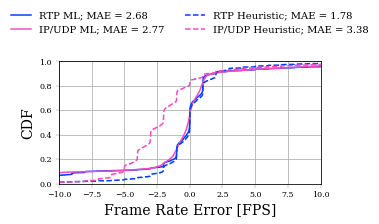

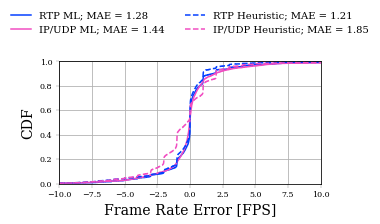

In [50]:
df_fps = df[(df['metric'] == 'framesReceivedPerSecond')]
df_fps = df_fps.rename(columns={'method': 'Method'})
plot_fps(df_fps, 'meet')
plot_fps(df_fps, 'teams')
# plot_fps(df_fps, 'webex')

In [51]:
df_meet = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'meet')]
df_teams = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'teams')]
df_webex = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'webex')]

print(100*len(df_meet[(df_meet['deviation'] >= -2)&(df_meet['deviation'] <= 2)])/len(df_meet))
print(100*len(df_teams[(df_teams['deviation'] >= -2)&(df_teams['deviation'] <= 2)])/len(df_teams))
# print(100*len(df_webex[(df_webex['deviation'] >= -2)&(df_webex['deviation'] <= 2)])/len(df_webex))

73.90823659480375
80.2370275464446


In [52]:
def plot_bitrate(df_bitrate, vca):
    meet = df_bitrate[df_bitrate['VCA'] == vca]
    labels = []
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth'])/1000, 2)
        d['Method'] = d['Method'].map({txt: txt + f"; MAE = {mae}"})
        labels.append(d)
        llabels[txt] =  txt + f"; MAE = {mae}"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'rel_deviation', ls=None, color='#023eff', ax=ax, label=llabels['RTP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'rel_deviation', ls=None, color='#f14cc1', ax=ax, label=llabels['IP/UDP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'rel_deviation', ls='--', color='#023eff', ax=ax, label=llabels['RTP Heuristic'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'rel_deviation', ls='--', color='#f14cc1', ax=ax, label=llabels['IP/UDP Heuristic'])
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, title="")
    plt.grid(visible=1)
    plt.xlim([-1, 1])
    plt.xlabel('Relative Bitrate Error')
    plt.ylabel('CDF')
    plt.savefig(f'paper_plots/{vca}_bitrate_error_netrics.pdf', bbox_inches='tight')

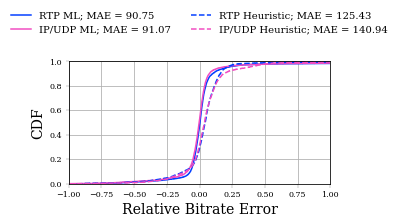

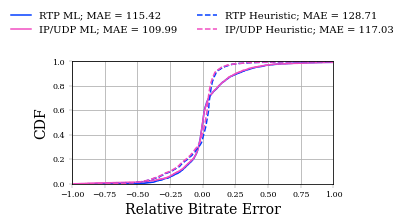

In [53]:
df_bitrate = df[(df['metric'] == 'bitrate')]
df_bitrate['deviation'] /= 1000
df_bitrate['rel_deviation'] = 1000 * df_bitrate['deviation'] / df_bitrate['Ground Truth']
df_bitrate = df_bitrate.rename(columns={'method': 'Method'})
plot_bitrate(df_bitrate, 'meet')
plot_bitrate(df_bitrate, 'teams')
# plot_bitrate(df_bitrate, 'webex')

In [54]:
df_meet = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'meet')]
df_teams = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'teams')]
df_webex = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'webex')]
print(100*len(df_meet[(df_meet['deviation'] >= -50)&(df_meet['deviation'] <= 50)])/len(df_meet))
print(100*len(df_teams[(df_teams['deviation'] >= -50)&(df_teams['deviation'] <= 50)])/len(df_teams))
# print(100*len(df_webex[(df_webex['deviation'] >= -50)&(df_webex['deviation'] <= 50)])/len(df_webex))

53.45494748479823
41.992312620115314


In [55]:
def plot_jitter(df_jitter, vca):
    meet = df_jitter[df_jitter['VCA'] == vca]
    labels = []
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth']), 2)
        d['Method'] = d['Method'].map({txt: txt + f"; MAE = {mae}"})
        labels.append(d)
        llabels[txt] =  txt + f"; MAE = {mae}"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'deviation', ls=None, color='#023eff', ax=ax, label=llabels['RTP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'deviation', ls=None, color='#f14cc1', ax=ax, label=llabels['IP/UDP ML'])
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'deviation', ls='--', color='#023eff', ax=ax, label=llabels['RTP Heuristic'])
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'deviation', ls='--', color='#f14cc1', ax=ax, label=llabels['IP/UDP Heuristic'])
    plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, title="")
    plt.grid(visible=1)
    plt.xlim([-100, 100])
    plt.xlabel('Frame Jitter Error [ms]')
    plt.ylabel('CDF')
    plt.savefig(f'paper_plots/{vca}_jitter_error_imc_zero_loss.pdf', bbox_inches='tight')

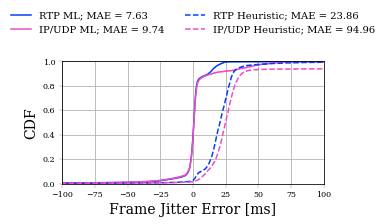

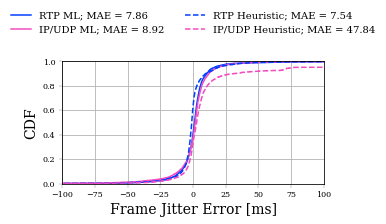

In [65]:
df_jitter = df[(df['metric'] == 'frame_jitter')]
df_jitter = df_jitter.rename(columns={'method': 'Method'})
plot_jitter(df_jitter, 'meet')
plot_jitter(df_jitter, 'teams')
# plot_jitter(df_jitter, 'webex')

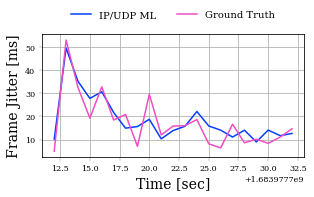

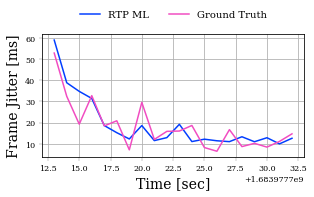

<Figure size 337.5x162 with 0 Axes>

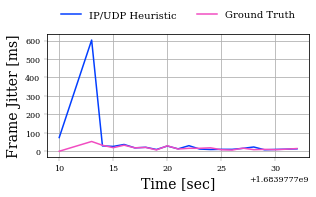

<Figure size 337.5x162 with 0 Axes>

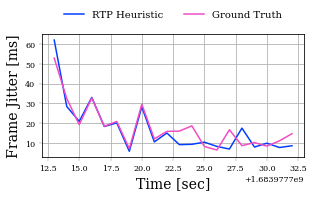

In [78]:
teams = df_jitter[df_jitter['VCA'] == 'teams']
csv_file = list(teams['csv_file'].unique())[7]
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('IP/UDP ML'))].sort_values(by='ts')
fig, ax = plt.subplots(1, 1)
tdf.plot('ts', 'Prediction', ax=ax, label=f'IP/UDP ML', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
# plt.ylim([0, 50])
# plt.xlim([0, 20])
# ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_ip_udp_ml_netrics.pdf', bbox_inches='tight')
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('RTP ML'))].sort_values(by='ts')
tdf.plot('ts', 'Prediction', ax=ax, label=f'RTP ML', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
# plt.ylim([0, 50])
# plt.xlim([0, 20])
# ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_rtp_ml.pdf', bbox_inches='tight')
plt.figure()
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('IP/UDP Heuristic'))].sort_values(by='ts')
tdf.plot('ts', 'Prediction', ax=ax, label=f'IP/UDP Heuristic', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
# plt.ylim([0, 50])
# plt.xlim([0, 20])
# ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_ip_udp_non_ml.pdf', bbox_inches='tight')
plt.figure()
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('RTP Heuristic'))].sort_values(by='ts')
tdf.plot('ts', 'Prediction', ax=ax, label=f'RTP Heuristic', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
# plt.ylim([0, 50])
# plt.xlim([0, 20])
# ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_rtp_non_ml_netrics.pdf', bbox_inches='tight')


meet


/home/taveesh/vca-qoe-inference/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/taveesh/vca-qoe-inference/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/taveesh/vca-qoe-inference/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


teams


/home/taveesh/vca-qoe-inference/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


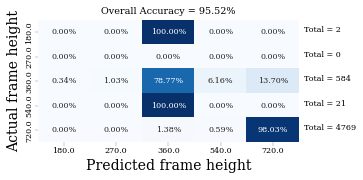

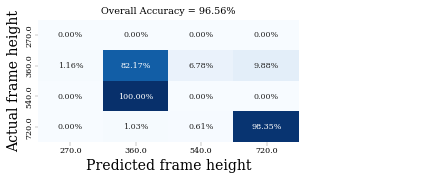

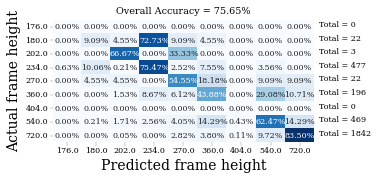

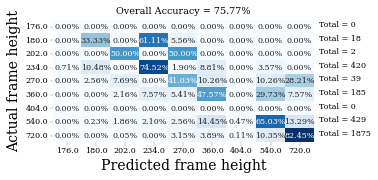

In [79]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

df_frameHeight = df[(df['metric'] == 'frameHeight')]

for vca in tested_vcas:
    teams = df_frameHeight[df_frameHeight['VCA'] == vca]
    print(vca)
    fig, ax = plt.subplots(1, 1)
    udp = teams[teams['method'] == 'IP/UDP ML']
    labels=sorted(list(udp['Ground Truth'].unique()))
    ccounts = np.unique(udp['Ground Truth'], return_counts=True)[1]
    cperc = ccounts / len(udp['Ground Truth'])
    cm = confusion_matrix(udp['Prediction'], udp['Ground Truth'], labels=labels)
    f1 = round(100*accuracy_score(udp['Prediction'], udp['Ground Truth']), 2)
    cm_norm = 100*cm / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0
    total = cm.sum(axis=1, keepdims=True).flatten()
    p = len(total)
    formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_norm.flatten()]).reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_norm, annot=formatted_text, cmap='Blues', fmt='', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    i = 0
    for x in total:
        plt.annotate(f"  Total = {x}", xy=(p, i+0.5))
        i += 1
    ax.tick_params(pad=1)
    ax.set_title(f'Overall Accuracy = {f1}%')
    ax.set_ylabel('Actual frame height')
    ax.set_xlabel('Predicted frame height')
    plt.savefig(f'paper_plots/{vca}_resolution_cm_netrics_ip.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1)
    rtp = teams[teams['method'] == 'RTP ML']
    labels=sorted(list(rtp['Ground Truth'].unique()))
    ccounts = np.unique(rtp['Ground Truth'], return_counts=True)[1]
    cperc = ccounts / len(rtp['Ground Truth'])
    cm = confusion_matrix(rtp['Prediction'], rtp['Ground Truth'], labels=labels)
    f1 = round(100*accuracy_score(rtp['Prediction'], rtp['Ground Truth']), 2)
    cm_norm = 100*cm / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0
    total = cm.sum(axis=1, keepdims=True).flatten()
    formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_norm.flatten()]).reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_norm, annot=formatted_text, cmap='Blues', fmt='', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    i = 0
    for x in total:
        plt.annotate(f"  Total = {x}", xy=(p, i+0.5))
        i += 1
    ax.tick_params(pad=1)
    ax.set_title(f'Overall Accuracy = {f1}%')
    ax.set_ylabel('Actual frame height')
    ax.set_xlabel('Predicted frame height')
    plt.savefig(f'paper_plots/{vca}_resolution_cm_netrics_rtp.pdf', bbox_inches='tight')

# Feature Importance Scores

In [88]:
def plot_feature_importance(f_rtp, f_udp, metric):
    for vca in f_rtp[metric][1].keys():
        print(vca)
        scores_rtp = {}
        for cv in f_rtp[metric].keys():
            for feature in f_rtp[metric][cv][vca].keys():
                if feature_map[feature] not in scores_rtp:
                    scores_rtp[feature_map[feature]] = []
                scores_rtp[feature_map[feature]].append(100*f_rtp[metric][cv][vca][feature])
        scores_udp = {}
        for cv in f_udp[metric].keys():
            for feature in f_udp[metric][cv][vca].keys():
                if feature_map[feature] not in scores_udp:
                    scores_udp[feature_map[feature]] = []
                scores_udp[feature_map[feature]].append(100*f_udp[metric][cv][vca][feature])
                
        mmap = {'framesReceivedPerSecond': 'Frames Per Second', 'bitrate': 'Bitrate', 'frame_jitter': 'Frame Jitter', 'frameHeight': 'FrameHeight'}
        if vca == 'meet':
            vc_name = 'Meet'
        elif vca == 'teams':
            vc_name = 'Teams'
        elif vca == 'webex':
            vc_name = 'Webex'
        
        fig, ax = plt.subplots(1, 1)
        topk = pd.DataFrame(scores_rtp).mean().sort_values(ascending=False).head(10).sort_values()
        plt.barh(topk.index, topk.values)
        plt.xlabel(f'Feature Importance [%]')
        plt.ylabel('Feature')
        plt.xlim([0, 100])
        plt.grid(visible=1)
        # ax.spines[['right', 'top']].set_visible(False)
        plt.savefig(f'paper_plots/{vca}_{metric}_rtp_ml_feature_importance_netrics.pdf', bbox_inches='tight')
        
        fig, ax = plt.subplots(1, 1)
        topk = pd.DataFrame(scores_udp).mean().sort_values(ascending=False).head(10).sort_values()
        plt.barh(topk.index, topk.values)
        plt.xlabel(f'Feature Importance [%]')
        plt.ylabel('Feature')
        plt.xlim([0, 100])
        plt.grid(visible=1)
        # ax.spines[['right', 'top']].set_visible(False)
        plt.savefig(f'paper_plots/{vca}_{metric}_ip_udp_ml_feature_importance_netrics.pdf', bbox_inches='tight')

meet
teams


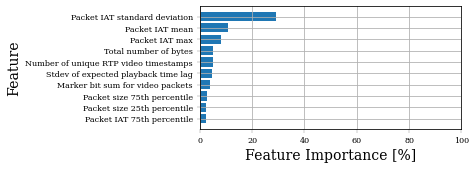

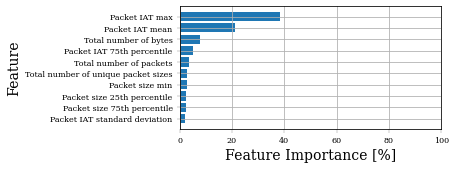

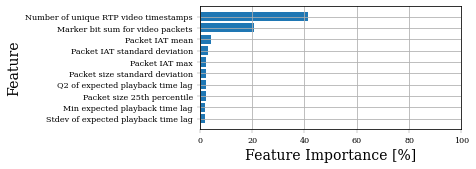

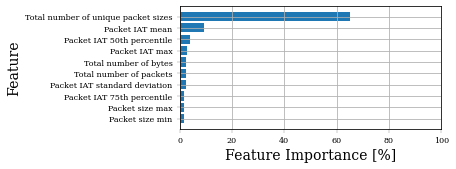

In [90]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'framesReceivedPerSecond')

meet
teams


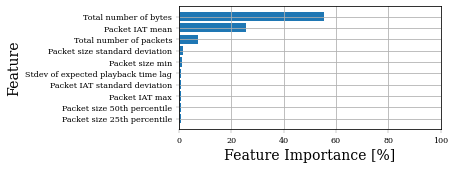

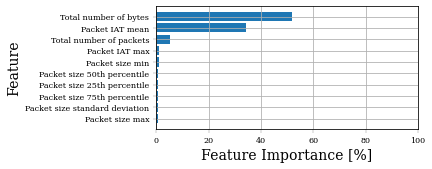

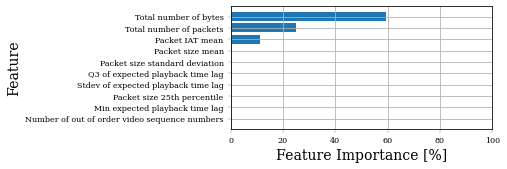

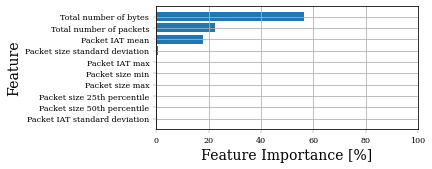

In [91]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'bitrate')

meet
teams


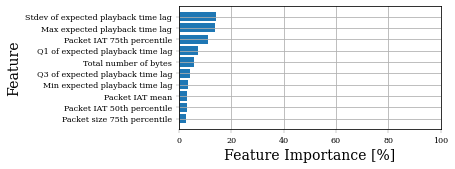

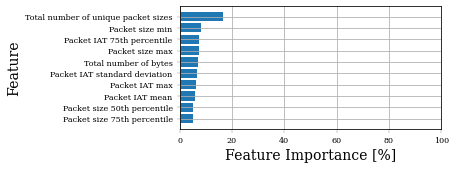

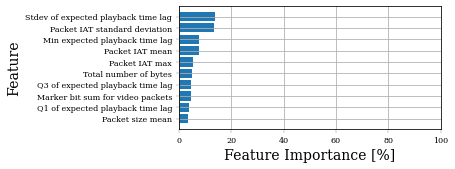

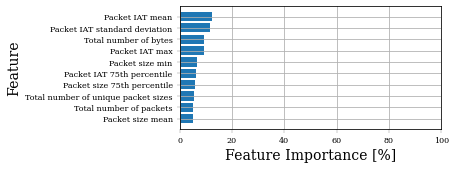

In [92]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'frame_jitter')

meet
teams


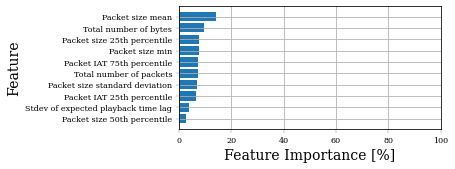

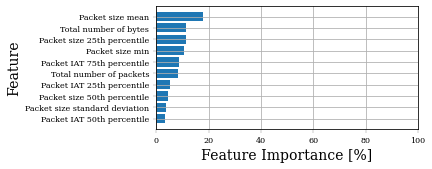

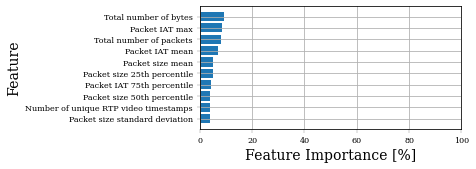

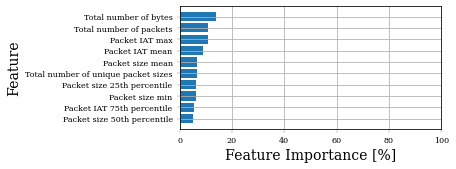

In [93]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'frameHeight')

### Ground Truth Distributions

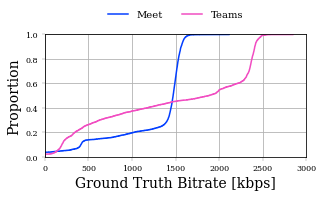

In [97]:
fig, ax = plt.subplots(1, 1)
df['bitrate_kbps'] = df['bitrate']/1000
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'bitrate_kbps', color = '#023eff', ax=ax, label='Meet')
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'bitrate_kbps', color='#f14cc1', ax=ax, label='Teams')
# sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'bitrate_kbps', color='#9f4800', ax=ax, label='Webex')
plt.xlabel('Ground Truth Bitrate [kbps]')
plt.grid(visible=1)
plt.xlim([0, 3000])
#add legend to plot
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False)
plt.savefig('paper_plots/gt_bitrate_netrics.pdf', bbox_inches='tight')

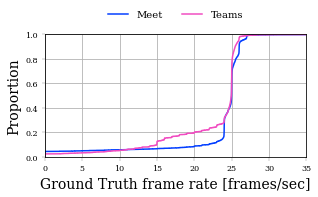

In [98]:
fig, ax = plt.subplots(1,1)
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'framesReceivedPerSecond', color = '#023eff', ax=ax, label='Meet')
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'framesReceivedPerSecond', color='#f14cc1', ax=ax, label='Teams')
# sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'framesReceivedPerSecond', color='#9f4800', ax=ax, label='Webex')
plt.legend(labels=['Meet', 'teams'])
plt.xlabel('Ground Truth frame rate [frames/sec]')
plt.grid(visible=1)
plt.xlim([0, 35])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, labels=['Meet', 'Teams'])
plt.savefig('paper_plots/gt_fps_netrics.pdf', bbox_inches='tight')

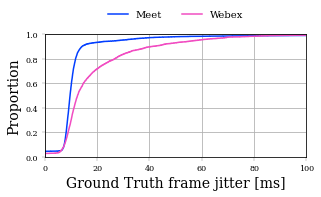

In [99]:
fig, ax = plt.subplots(1,1)
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'frame_jitter', color = '#023eff', ax=ax, label='Meet')
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'frame_jitter', color='#f14cc1', ax=ax, label='Teams')
plt.legend(labels=['Meet', 'Teams'])
plt.xlabel('Ground Truth frame jitter [ms]')
plt.grid(visible=1)
plt.xlim([0, 100])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, labels=['Meet', 'Webex'])
plt.savefig('paper_plots/gt_interframe_delay_std_netrics.pdf', bbox_inches='tight')

# Packet Size Distribution Meet vs Teams

In [101]:
print(df.columns)

Index(['Prediction', 'Ground Truth', 'timestamp', 'pcap_file', 'cross_val', 'metric', 'method', 'VCA', 'deviation', 'abs_deviation', 'ts', 'ssrc', 'lastPacketReceivedTimestamp', 'framesPerSecond', 'bitrate', '[codec]', 'packetsLost', 'framesDropped', 'framesReceived', 'framesReceivedPerSecond', 'frame_jitter', 'nackCount', 'packetsReceived', 'trackIdentifier', 'freezeCount', 'totalFreezesDuration', 'pauseCount', 'totalPausesDuration', 'jitterBufferDelay', 'framesDecodedPerSecond', 'jitterBufferEmittedCount', 'frameHeight', 'qpSum', 'duration', 'num_vals', 'csv_file', 'webrtc_file', 'bitrate_kbps'], dtype='object')


In [87]:
import pandas as pd
mcsv = df[df['device_id'] == 'nm']
mw = WebRTCReader('../../data/conext_data/logs_Meet_06-15_rush_hour/webrtc/3086_528_27783_259_53_1655334546.json', 'conext_data').get_webrtc()
tw = WebRTCReader('../../data/conext_data/logs_Teams_06-15_rush_hour/webrtc/3085_999_198994_74624_50_1655406559.json', 'conext_data').get_webrtc()
tcsv = '../../data/conext_data/logs_Teams_06-15_rush_hour/capture/3085_999_198994_74624_50_1655406559.csv'
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
m = pd.read_csv(mcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
t = pd.read_csv(tcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
m = m[m['udp.length'] > 304]
t = t[t['udp.length'] > 304]

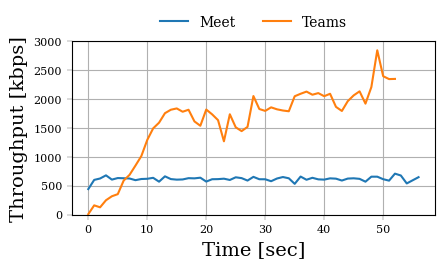

In [88]:
m['ts'] = m['frame.time_epoch'].apply(int)
t['ts'] = t['frame.time_epoch'].apply(int)
m = m.groupby('ts')['udp.length'].sum().reset_index()
t = t.groupby('ts')['udp.length'].sum().reset_index()
mw['bitrate'] /= 1000
m['udp.length'] *= (8/1000)
tw['bitrate'] /= 1000
t['udp.length'] *= (8/1000)
m_ = pd.merge(m, mw, on='ts')
t_ = pd.merge(t, tw, on='ts')
m_['ts_rel'] = m_['ts']-m_['ts'].min()
t_['ts_rel'] = t_['ts']-t_['ts'].min()
fig, ax = plt.subplots(1,1)
m_.groupby('ts_rel')[['udp.length']].max().plot(label='Meet', ax=ax)
t_.groupby('ts_rel')[['udp.length']].max().plot(label='Teams', ax=ax)
plt.xlabel('Time [sec]')
plt.ylabel('Throughput [kbps]')
plt.ylim([0, 3000])
plt.grid(visible=1)
plt.legend(labels=['Meet', 'Teams'], loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False)
plt.savefig('paper_plots/throughput_comparison.pdf', bbox_inches='tight')

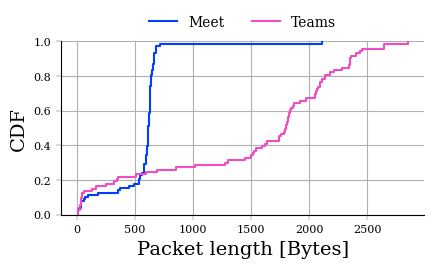

In [89]:
fig, ax = plt.subplots(1, 1)

sns.ecdfplot(data=m, x = 'udp.length', color='#023eff')
sns.ecdfplot(data=t, x = 'udp.length', color= '#f14cc1')
plt.grid(visible=1)
plt.legend(labels=['Meet', 'Teams'], loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False)
plt.xlabel('Packet length [Bytes]')
plt.ylabel('CDF')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/udp_length_comparison.pdf', bbox_inches='tight')

# Lookback Tuning

In [96]:
%run '../qoe_estimation/frame_lookback/model.py'
%run '../config.py'
# %run './lookback_tuning.py' #Generates the CSVs

L
1    4.61
2    4.09
3    4.00
4    3.90
5    3.70
6    3.57
7    3.51
8    3.46
9    3.39
10   3.30
Name: MAE, dtype: float64


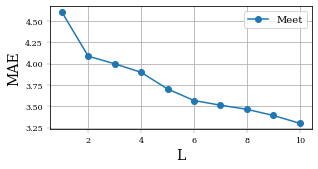

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
# dfl1 = pd.read_csv('webex_lookback_imc_zero_loss.csv')
# print(dfl1.groupby('L')['MAE'].mean())

dfl2 = pd.read_csv('meet_lookback_netrics.csv')
print(dfl2.groupby('L')['MAE'].mean())
fig, ax = plt.subplots(1, 1)
# dfl1.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Webex')
dfl2.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Meet')
ax.set_ylabel('MAE')
ax.grid(visible=1)
ax.legend()

In [167]:
dfl1.columns

Index(['csv_file', 'frac_interleave', 'frac_coalesce', 'L', 'MAE'], dtype='object')

In [168]:
dfl1.groupby('L')[['frac_coalesce', 'frac_interleave']].mean().mul(100)

,frac_coalesce,frac_interleave
L,,
1,6.09,1.12
2,6.93,1.08
3,8.37,1.06
4,9.54,1.05
5,11.01,1.04
6,12.10,1.02
7,13.68,1.01
8,14.54,1.00
9,15.71,0.99


In [169]:
dfl2.groupby('L')[['frac_coalesce', 'frac_interleave']].mean().mul(100)

,frac_coalesce,frac_interleave
L,,
1,0.38,7.13
2,0.57,7.12
3,0.76,7.11
4,1.40,7.11
5,2.31,7.06
6,2.70,7.04
7,2.91,7.03
8,3.18,7.02
9,3.67,7.01


# Coalesces and Interleaves

In [170]:
df_files = pd.read_csv('conext_results.csv', index_col=None)
vca_data = {'VCA': [], 'Interleaves': [], 'Coalesces': []}
for vca in ['meet', 'teams']:
    print(vca)
    thresh = 1 if vca == 'meet' else 1
    for file_tuple in df_files[df_files['VCA'] == vca].groupby(['pcap_file','csv_file', 'webrtc_file']).groups.keys():
        pcap_file = file_tuple[0]
        csv_file = file_tuple[1]
        webrtc_file = file_tuple[2]
        net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
        df = pd.read_csv(csv_file, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
        dfg = dfn.groupby('rtp.timestamp').agg(max_size=('udp.length', max), min_size = ('udp.length', min)).reset_index()
        if df['ip.proto'].dtype == object:
            df = df[df['ip.proto'].str.contains(',') == False]
        df = df[~df['ip.proto'].isna()]
        df['ip.proto'] = df['ip.proto'].astype(int)
        df = df[(df['ip.proto'] == 17) & (df['ip.dst'] == '192.168.1.107')]
        src = df.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
        df = df[df['ip.src'] == src]

        df = df[df['udp.length'] > 306]
        df = df.sort_values(by=['frame.time_relative'])
        frame_id_assignment = [-1 for _ in range(df.shape[0])]
        frame_id = 1
        l = 1
        for i in range(df.shape[0]):
            found = False
            s = df.iloc[i]['udp.length']
            for j in range(max(0, i-l), i):
                if abs(df.iloc[j]['udp.length'] - s) <= thresh:
                    frame_id_assignment[i] = frame_id
                    found = True
                    break
            if not found:
                frame_id += 1
                frame_id_assignment[i] = frame_id
        df["frame_num"] = frame_id_assignment
        dfc = df.groupby("frame_num").agg({"rtp.timestamp": (lambda x: len(set(x)))})
        coal = len(dfc[dfc["rtp.timestamp"] > 1]) / len(dfc)
        dfi = df.groupby("rtp.timestamp").agg({"frame_num": (lambda x: len(set(x)))})
        il = len(dfi[dfi["frame_num"] > 1]) / len(dfi)
        vca_data["VCA"].append(vca)
        vca_data["Interleaves"].append(il)
        vca_data["Coalesces"].append(coal)
df_err = pd.DataFrame(vca_data)
df_err.to_csv('coal_ileav.csv', index=False)

meet
teams


In [171]:
df_err = pd.read_csv('coal_ileav.csv')
df_err.groupby('VCA')[['Interleaves', 'Coalesces']].mean().mul(100)

,Interleaves,Coalesces
VCA,,
meet,7.13,0.38
teams,1.13,2.86


## Meet FPS Overestimation Analysis

In [172]:
csv_file = "../../data/conext_data/logs_Meet_06-15_rush_hour/capture/1010_78_3455_278_49_1655323428.csv"
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
df = pd.read_csv(csv_file, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
dfg = df.groupby('rtp.timestamp').agg(max_size=('udp.length', max), min_size = ('udp.length', min)).reset_index()
if df['ip.proto'].dtype == object:
    df = df[df['ip.proto'].str.contains(',') == False]
df = df[~df['ip.proto'].isna()]
df['ip.proto'] = df['ip.proto'].astype(int)
df = df[(df['ip.proto'] == 17) & (df['ip.dst'] == '192.168.1.187')]
src = df.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
df = df[df['ip.src'] == src]

df = df[df['udp.length'] > 306]
df = df.sort_values(by=['frame.time_relative'])
frame_id_assignment = [-1 for _ in range(df.shape[0])]
frame_id = 1
l = 10
for i in range(df.shape[0]):
    found = False
    s = df.iloc[i]['udp.length']
    for j in range(max(0, i-l), i):
        if abs(df.iloc[j]['udp.length'] - s) <= 2:
            frame_id_assignment[i] = frame_id
            found = True
            break
    if not found:
        frame_id += 1
        frame_id_assignment[i] = frame_id
df["frame_num"] = frame_id_assignment
dfc = df.groupby("frame_num").agg({"rtp.timestamp": (lambda x: len(set(x)))})
coal = len(dfc[dfc["rtp.timestamp"] > 1]) / len(dfc)
dfi = df.groupby("rtp.timestamp").agg({"frame_num": (lambda x: len(set(x)))})
il = len(dfi[dfi["frame_num"] > 1]) / len(dfi)

## Toy Example

11 13


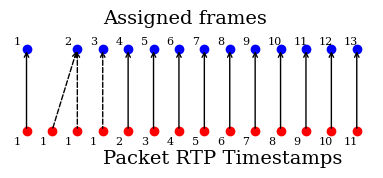

In [173]:
from collections import defaultdict
df['et'] = df['frame.time_relative'].apply(int)
dfs = df[(df['et'] == 11)]
rtps = dfs['rtp.timestamp'].tolist()
fnums = dfs['frame_num'].tolist()
times = dfs['frame.time_relative'].tolist()
rtp_set = sorted(list(set(rtps)))
fnum_set = sorted(list(set(fnums)))
print(len(rtp_set), len(fnum_set))
rtp_idx = {rtp_set[i]: i for i in range(len(rtp_set))}
fnum_idx = {fnum_set[i]: i for i in range(len(fnum_set))}
rel = [(i, fnum_idx[fnums[i]]) for i in range(len(rtps))]
max_idx = defaultdict(lambda: -1)
for a, b in rel:
    max_idx[b] = max(max_idx[b], a)
top_x = [max_idx[x] for x in max_idx.keys()]
a_y_ = sorted(rtps)
b_y_ = sorted(fnums)
a_y = [rtp_idx[x] for x in a_y_]
b_y = [fnum_idx[x] for x in b_y_]
a_x = [1 for i in range(len(a_y))]
b_x = [2 for i in range(len(fnum_idx))]
plt.figure(figsize=(1.5*3.125, 1.5))
plt.scatter(list(range(len(a_y))), a_x, c='r')
plt.scatter(top_x, b_x, c='b')
plt.margins(y=0.2)
for i in range(len(rtps)):
    plt.annotate(xy=(i-0.5, 0.83), text=f'{rtp_idx[rtps[i]]+1}', fontsize=8)
for i in range(len(fnum_idx)):
    plt.annotate(xy=(max_idx[i]-0.5, 2+0.045), text=f'{i+1}', fontsize=8)
for i1, i2 in rel:
    if i1 in [1, 2, 3]:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-', ls = '--') , text='')
    else:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-') , text='')
plt.text(x =3, y = 0.6, s = 'Packet RTP Timestamps', fontsize=14)
plt.text(x =3, y = 2.3, s = 'Assigned frames', fontsize=14)
plt.yticks([])
plt.xticks([])
plt.box(False)
plt.savefig('paper_plots/coalesces.pdf', bbox_inches='tight')

In [174]:
dfs

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp,rtp.seq,rtp.p_type,rtp.marker,frame_num,et
1066,11.89,1655323442.94,142.250.82.185,192.168.1.107,17,1167.00,3478.00,62887.00,1147.00,0xcee588da,1880642379.00,0.00,98,0.00,6,11
1069,11.90,1655323442.95,142.250.82.185,192.168.1.107,17,1179.00,3478.00,62887.00,1159.00,0xcee588da,1880642379.00,1.00,98,0.00,7,11
1071,11.91,1655323442.96,142.250.82.185,192.168.1.107,17,1179.00,3478.00,62887.00,1159.00,0xcee588da,1880642379.00,2.00,98,0.00,7,11
1073,11.92,1655323442.97,142.250.82.185,192.168.1.107,17,1175.00,3478.00,62887.00,1155.00,0xcee588da,1880642379.00,3.00,98,1.00,8,11
1078,11.93,1655323442.98,142.250.82.185,192.168.1.107,17,416.00,3478.00,62887.00,396.00,0xcee588da,1880646069.00,4.00,98,1.00,9,11
1080,11.93,1655323442.98,142.250.82.185,192.168.1.107,17,570.00,3478.00,62887.00,550.00,0xcee588da,1880650209.00,5.00,98,1.00,10,11
1086,11.94,1655323442.99,142.250.82.185,192.168.1.107,17,603.00,3478.00,62887.00,583.00,0xcee588da,1880653179.00,6.00,98,1.00,11,11
1089,11.95,1655323443.00,142.250.82.185,192.168.1.107,17,918.00,3478.00,62887.00,898.00,0xcee588da,1880657319.00,7.00,98,1.00,12,11
1092,11.96,1655323443.01,142.250.82.185,192.168.1.107,17,587.00,3478.00,62887.00,567.00,0xcee588da,1880660199.00,8.00,98,1.00,13,11
1096,11.96,1655323443.01,142.250.82.185,192.168.1.107,17,637.00,3478.00,62887.00,617.00,0xcee588da,1880664339.00,9.00,98,1.00,14,11


<Axes: xlabel='udp.length', ylabel='Proportion'>

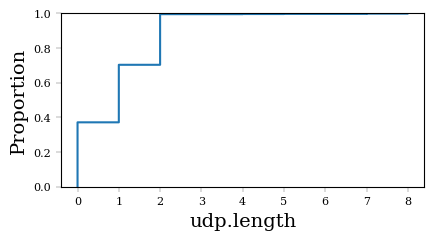

In [78]:
wcsv = '../../data/IMC_Zero_Loss/2023-05-13_webex_1102_698_79_49_0_83/webex/captures/webex-chrome-1102_698_79_49_0_83-1684013286.csv'
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306)]
dw = m.groupby('rtp.timestamp').agg({'udp.length': lambda x: max(x)-min(x)}).reset_index()
sns.ecdfplot(data=dw, x='udp.length')

In [79]:
m.groupby('rtp.p_type')['udp.length'].mean()

rtp.p_type
102.00   954.87
Name: udp.length, dtype: float64

<Axes: xlabel='udp.length', ylabel='Proportion'>

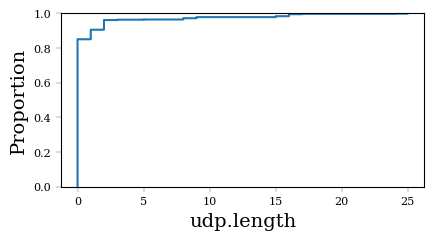

In [80]:
mcsv = '../../data/IMC_Zero_Loss/2023-05-14_meet_1102_698_79_49_0_83/meet/captures/meet-chrome-1102_698_79_49_0_83-1684053978.csv'
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
m = pd.read_csv(mcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306)]
dw = m.groupby('rtp.timestamp').agg({'udp.length': lambda x: max(x)-min(x)}).reset_index()
sns.ecdfplot(data=dw, x='udp.length')

<Axes: xlabel='udp.length', ylabel='Proportion'>

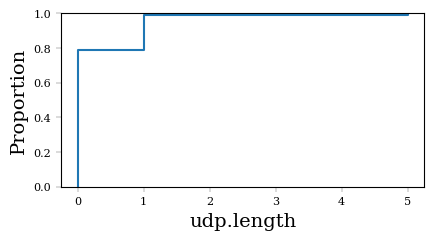

In [87]:
wcsv = '../../data/IMC_Zero_Loss/2023-05-14_teams_116_46_402_272_0_50/teams/captures/teams-chrome-116_46_402_272_0_50-1684097202.csv'
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306)]
dw = m.groupby('rtp.timestamp').agg({'udp.length': lambda x: max(x)-min(x), 'rtp.p_type': max}).reset_index()
sns.ecdfplot(data=dw, x='udp.length')

In [88]:
m[m['rtp.p_type'] == 103]

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp,rtp.seq,rtp.p_type,rtp.marker
5898,77.61,1684097280.69,52.113.18.245,192.168.1.187,17,493,3480.00,33125.00,473.00,0x0000a3ae,301015511.00,1401.00,103.00,1.00
5900,77.61,1684097280.69,52.113.18.245,192.168.1.187,17,524,3480.00,33125.00,504.00,0x0000a3ae,301040836.00,1403.00,103.00,1.00
5902,77.61,1684097280.69,52.113.18.245,192.168.1.187,17,464,3480.00,33125.00,444.00,0x0000a3ae,301061925.00,1405.00,103.00,1.00
5989,79.59,1684097282.67,52.113.18.245,192.168.1.187,17,400,3480.00,33125.00,380.00,0x0000a3ae,301075796.00,1419.00,103.00,1.00
5990,79.59,1684097282.67,52.113.18.245,192.168.1.187,17,432,3480.00,33125.00,412.00,0x0000a3ae,301097824.00,1420.00,103.00,1.00
